In [1]:
import ee
import json
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

print("=" * 60)
print("OTSU THRESHOLD VALIDATION - SEPTEMBER 23, 2025")
print("=" * 60)

# Initialize GEE
ee.Initialize(project='kolkata-flood-mapping')
print("✓ Earth Engine initialized")

# Load wards
DATA_DIR = Path('../data')
WARDS_DIR = DATA_DIR / 'wards'
VALIDATION_DIR = DATA_DIR / 'validation'
VALIDATION_DIR.mkdir(parents=True, exist_ok=True)

wards = gpd.read_file(WARDS_DIR / 'kmc_wards_gee_ready.geojson')
wards['ward_id'] = wards['WARD'].astype(str).str.strip()

print(f"✓ Loaded {len(wards)} wards")

# Get Sentinel-1 for September 23, 2025 (flood peak day)
print("\n📡 Loading Sentinel-1 SAR for September 23, 2025 (flood peak)...")

roi = ee.Geometry.Rectangle([88.24, 22.45, 88.46, 22.64])

s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
  .filterBounds(roi) \
  .filterDate('2025-09-23', '2025-09-24') \
  .filter(ee.Filter.eq('instrumentMode', 'IW')) \
  .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
  .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))

print(f"Images found: {s1.size().getInfo()}")

if s1.size().getInfo() > 0:
    sar_img = s1.first()

    # Get image date/time
    img_date = ee.Date(sar_img.get('system:time_start'))
    print(f"✓ Using image from: {img_date.format('YYYY-MM-dd HH:mm').getInfo()}")
    print(f"  (This should show flood extent from Sep 23!)")

    # Apply speckle filter (from Raviraj's script)
    vv = sar_img.select('VV')
    vh = sar_img.select('VH')

    vv_filtered = vv.focal_median(100, 'circle', 'meters').rename('VV_Filtered')
    vh_filtered = vh.focal_median(100, 'circle', 'meters').rename('VH_Filtered')

    sar_filtered = sar_img.addBands(vv_filtered).addBands(vh_filtered)

    print("✓ Applied 100m focal median speckle filter")
    print("\n✅ SAR image ready for Otsu validation!")

else:
    print("❌ No SAR image found for Sep 23, 2025")
    print("   Trying Sep 22-24 range...")

    s1_range = ee.ImageCollection('COPERNICUS/S1_GRD') \
      .filterBounds(roi) \
      .filterDate('2025-09-22', '2025-09-25') \
      .filter(ee.Filter.eq('instrumentMode', 'IW')) \
      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))

    print(f"   Images in Sep 22-24: {s1_range.size().getInfo()}")

    if s1_range.size().getInfo() > 0:
        sar_img = s1_range.first()
        img_date = ee.Date(sar_img.get('system:time_start'))
        print(f"   Using closest: {img_date.format('YYYY-MM-dd').getInfo()}")

OTSU THRESHOLD VALIDATION - SEPTEMBER 23, 2025
✓ Earth Engine initialized
✓ Loaded 141 wards

📡 Loading Sentinel-1 SAR for September 23, 2025 (flood peak)...
Images found: 1
✓ Using image from: 2025-09-23 23:56
  (This should show flood extent from Sep 23!)
✓ Applied 100m focal median speckle filter

✅ SAR image ready for Otsu validation!


In [2]:
print("\n⚙️  Defining Otsu threshold function...")

# Otsu's method adapted for Earth Engine Python API
# From Raviraj Dave's script, converted to Python

def otsu_threshold_gee(histogram_dict):
    """
    Calculate optimal threshold using Otsu's method
    Works with GEE histogram dictionary
    """
    counts = ee.Array(histogram_dict.get('histogram'))
    means = ee.Array(histogram_dict.get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum_val = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum_val.divide(total)

    indices = ee.List.sequence(1, size)

    # Calculate between-class variance for each possible threshold
    def calc_variance(i):
        i = ee.Number(i)
        aCounts = counts.slice(0, 0, i)
        aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
        aMeans = means.slice(0, 0, i)
        aMean = aMeans.multiply(aCounts) \
            .reduce(ee.Reducer.sum(), [0]).get([0]) \
            .divide(aCount)
        bCount = total.subtract(aCount)
        bMean = sum_val.subtract(aCount.multiply(aMean)).divide(bCount)

        # Between-class variance
        return aCount.multiply(aMean.subtract(mean).pow(2)).add(
               bCount.multiply(bMean.subtract(mean).pow(2)))

    bss = indices.map(calc_variance)

    # Return mean value with maximum between-class variance
    return means.sort(bss).get([-1])

print("✓ Otsu function defined (Python version)")
print("  Minimizes intra-class variance to find optimal water threshold")


⚙️  Defining Otsu threshold function...
✓ Otsu function defined (Python version)
  Minimizes intra-class variance to find optimal water threshold


In [4]:
print("\n🧪 TESTING OTSU ON SAMPLE WARDS...")

# Select sample wards
# From news: Behala (74), Topsia area (107, 108) flooded
# Northern/western wards: Less affected

sample_wards = {
    'flooded': ['74', '107', '108', '106', '109'],  # Known flooded (eastern/southern)
    'safe': ['1', '2', '3', '4', '5']                # Northern/western (less flooded)
}

print(f"\n📊 Flooded wards (expected water): {sample_wards['flooded']}")
print(f"📊 Safe wards (less water): {sample_wards['safe']}")

results = []

for category, ward_ids in sample_wards.items():
    print(f"\n{'='*50}")
    print(f"{category.upper()} WARDS:")
    print(f"{'='*50}")

    for ward_id in ward_ids:
        ward_data = wards[wards['ward_id'] == ward_id]

        if len(ward_data) > 0:
            ward = ward_data.iloc[0]

            # Use ward bounding box (avoids geometry conversion)
            ward_bounds = ward.geometry.bounds  # (minx, miny, maxx, maxy)
            ward_bbox = ee.Geometry.Rectangle([
                ward_bounds[0], ward_bounds[1],
                ward_bounds[2], ward_bounds[3]
            ])

            try:
                # Calculate histogram
                vv = sar_filtered.select('VV_Filtered')

                histogram = vv.reduceRegion(
                    reducer=ee.Reducer.histogram(255, 2),
                    geometry=ward_bbox,
                    scale=10,
                    bestEffort=True,
                    maxPixels=1e9
                )

                # Apply Otsu
                threshold = otsu_threshold_gee(histogram.get('VV_Filtered_histogram')).getInfo()

                # Get mean VV
                mean_vv = vv.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=ward_bbox,
                    scale=10,
                    maxPixels=1e9
                ).get('VV_Filtered').getInfo()

                # Classify water (VV < threshold = water)
                water_detected = mean_vv < threshold

                print(f"\n  Ward {ward_id} ({category}):")
                print(f"    Otsu threshold: {threshold:.2f} dB")
                print(f"    Mean VV backscatter: {mean_vv:.2f} dB")
                print(f"    Water detected: {'✓ YES' if water_detected else '✗ NO'}")
                print(f"    Match expected: {'✓' if (water_detected and category=='flooded') or (not water_detected and category=='safe') else '✗ MISMATCH'}")

                results.append({
                    'ward_id': ward_id,
                    'category': category,
                    'otsu_threshold_dB': threshold,
                    'mean_vv_dB': mean_vv,
                    'water_detected': water_detected,
                    'matches_expected': (water_detected and category=='flooded') or (not water_detected and category=='safe')
                })

            except Exception as e:
                print(f"\n  Ward {ward_id}: Error - {e}")

# Create results DataFrame
results_df = pd.DataFrame(results)

print(f"\n" + "=" * 60)
print("OTSU VALIDATION RESULTS SUMMARY")
print("=" * 60)

if len(results_df) > 0:
    print(f"\n📊 Threshold Statistics:")
    flooded = results_df[results_df['category'] == 'flooded']
    safe = results_df[results_df['category'] == 'safe']

    if len(flooded) > 0:
        print(f"   Flooded wards:")
        print(f"      Mean threshold: {flooded['otsu_threshold_dB'].mean():.2f} dB")
        print(f"      Mean VV: {flooded['mean_vv_dB'].mean():.2f} dB")
        print(f"      Water detected: {flooded['water_detected'].sum()}/{len(flooded)}")

    if len(safe) > 0:
        print(f"\n   Safe wards:")
        print(f"      Mean threshold: {safe['otsu_threshold_dB'].mean():.2f} dB")
        print(f"      Mean VV: {safe['mean_vv_dB'].mean():.2f} dB")
        print(f"      Water detected: {safe['water_detected'].sum()}/{len(safe)}")

    # Overall accuracy
    accuracy = results_df['matches_expected'].sum() / len(results_df) * 100
    print(f"\n✓ Otsu classification accuracy: {accuracy:.0f}%")
    print(f"  ({results_df['matches_expected'].sum()}/{len(results_df)} wards correctly classified)")

    print(f"\n💡 KEY INSIGHTS:")
    if len(flooded) > 0 and len(safe) > 0:
        threshold_diff = flooded['otsu_threshold_dB'].mean() - safe['otsu_threshold_dB'].mean()
        print(f"   • Threshold adapts by ward: {abs(threshold_diff):.2f} dB difference")
        print(f"   • Adaptive thresholding {'✓ WORKS' if abs(threshold_diff) > 1 else '~ similar thresholds'}")

    # Save
    results_df.to_csv(VALIDATION_DIR / 'otsu_validation_sep23.csv', index=False)
    print(f"\n✓ Saved: {VALIDATION_DIR / 'otsu_validation_sep23.csv'}")

print("\n✅ OTSU VALIDATION COMPLETE!")
print("\n🎯 Ready to process all 1,989 SAR dates with Otsu in Week 3!")
print("\n🌙 Great work today - rest well!")


🧪 TESTING OTSU ON SAMPLE WARDS...

📊 Flooded wards (expected water): ['74', '107', '108', '106', '109']
📊 Safe wards (less water): ['1', '2', '3', '4', '5']

FLOODED WARDS:

  Ward 74: Error - 'ComputedObject' object has no attribute 'get'

  Ward 107: Error - 'ComputedObject' object has no attribute 'get'

  Ward 108: Error - 'ComputedObject' object has no attribute 'get'

  Ward 106: Error - 'ComputedObject' object has no attribute 'get'

  Ward 109: Error - 'ComputedObject' object has no attribute 'get'

SAFE WARDS:

  Ward 1: Error - 'ComputedObject' object has no attribute 'get'

  Ward 2: Error - 'ComputedObject' object has no attribute 'get'

  Ward 3: Error - 'ComputedObject' object has no attribute 'get'

  Ward 4: Error - 'ComputedObject' object has no attribute 'get'

  Ward 5: Error - 'ComputedObject' object has no attribute 'get'

OTSU VALIDATION RESULTS SUMMARY

✅ OTSU VALIDATION COMPLETE!

🎯 Ready to process all 1,989 SAR dates with Otsu in Week 3!

🌙 Great work today -

In [5]:
print("\n🧪 SIMPLIFIED OTSU TEST (Fixed)...")

# Just test with FIXED threshold for tonight (validate concept)
# Full Otsu implementation tomorrow when we have more time

sample_wards_test = {
    'flooded': ['74', '107', '108'],
    'safe': ['1', '2', '3']
}

print("\n📊 Testing with fixed threshold (-15 dB) vs adaptive would be...")

results_simple = []

for category, ward_ids in sample_wards_test.items():
    print(f"\n{category.upper()}:")

    for ward_id in ward_ids[:2]:  # Just 2 per category for quick test
        ward_data = wards[wards['ward_id'] == ward_id]

        if len(ward_data) > 0:
            ward_bounds = ward_data.iloc[0].geometry.bounds
            ward_bbox = ee.Geometry.Rectangle([
                ward_bounds[0], ward_bounds[1],
                ward_bounds[2], ward_bounds[3]
            ])

            # Simple approach: Get mean VV
            vv = sar_filtered.select('VV_Filtered')

            stats = vv.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=ward_bbox,
                scale=10
            )

            mean_vv = stats.get('VV_Filtered').getInfo()

            # Use fixed threshold for tonight
            threshold_fixed = -15.0
            water_detected = mean_vv < threshold_fixed

            print(f"  Ward {ward_id}:")
            print(f"    Mean VV: {mean_vv:.2f} dB")
            print(f"    Water (VV < -15): {'✓ YES' if water_detected else '✗ NO'}")

print("\n✅ QUICK VALIDATION COMPLETE!")
print("\nFull Otsu processing strategy for tomorrow...")


🧪 SIMPLIFIED OTSU TEST (Fixed)...

📊 Testing with fixed threshold (-15 dB) vs adaptive would be...

FLOODED:


TypeError: '<' not supported between instances of 'NoneType' and 'float'

In [6]:
print("\n🧪 QUICK SAR CHECK (Minimal Test)...")

# Just verify SAR image is accessible and has data
print("Checking if Sep 23 SAR image has data...")

# Get first image
if s1.size().getInfo() > 0:
    sar_img = s1.first()

    # Check one ward's data
    test_ward = wards[wards['ward_id'] == '74'].iloc[0]
    test_bounds = test_ward.geometry.bounds
    test_bbox = ee.Geometry.Rectangle([
        test_bounds[0], test_bounds[1],
        test_bounds[2], test_bounds[3]
    ])

    # Get raw VV stats
    vv_raw = sar_img.select('VV')

    stats = vv_raw.reduceRegion(
        reducer=ee.Reducer.mean().combine(
            reducer2=ee.Reducer.minMax(),
            sharedInputs=True
        ),
        geometry=test_bbox,
        scale=10,
        maxPixels=1e9
    ).getInfo()

    print(f"\n✓ Ward 74 (flooded) SAR statistics:")
    print(f"   {stats}")

    if stats.get('VV_mean'):
        mean_vv = stats.get('VV_mean')
        print(f"\n   Mean VV: {mean_vv:.2f} dB")
        print(f"   Water likely present: {mean_vv < -15}")
        print("\n✅ SAR data accessible!")
        print("Full Otsu validation tomorrow after GEE asset upload")
    else:
        print("⚠️  No data returned - checking image")

print("\n🌙 That's enough for tonight!")
print("Tomorrow: Upload wards to GEE asset, then full Otsu + SWMM")


🧪 QUICK SAR CHECK (Minimal Test)...
Checking if Sep 23 SAR image has data...

✓ Ward 74 (flooded) SAR statistics:
   {'VV_max': None, 'VV_mean': None, 'VV_min': None}
⚠️  No data returned - checking image

🌙 That's enough for tonight!
Tomorrow: Upload wards to GEE asset, then full Otsu + SWMM


In [7]:
print("=" * 60)
print("VALIDATING OTSU THRESHOLD")
print("=" * 60)

print("🎯 Dr. Puja Das feedback: 'Threshold needs tuning'")
print("   Testing our -14.90 dB against known water bodies\n")

# Load a dry season image
test_date = '2024-01-15'  # Mid dry season, clear day
test_img = s1_full.filterDate(test_date, ee.Date(test_date).advance(1, 'day')).first()

# Apply speckle filter
vv_filt = test_img.select('VV').focalMedian(100, 'circle', 'meters')

# Calculate histogram
histogram = vv_filt.reduceRegion(
    reducer=ee.Reducer.histogram(255, 2),
    geometry=kmc_bbox,
    scale=10,
    bestEffort=True,
    maxPixels=1e9
).getInfo()

hist_data = histogram['VV']
counts = np.array(hist_data['histogram'])
means = np.array(hist_data['bucketMeans'])

# Show full histogram
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Full histogram
ax1 = axes[0, 0]
ax1.bar(means, counts, width=means[1]-means[0], edgecolor='black', alpha=0.7)
ax1.axvline(x=-14.90, color='red', linewidth=3, label='Our Otsu: -14.90 dB')
ax1.axvline(x=-15, color='orange', linewidth=2, linestyle='--', label='Typical water: -15 dB')
ax1.axvline(x=-12, color='green', linewidth=2, linestyle='--', label='Shallow water: -12 dB')
ax1.set_xlabel('Backscatter (dB)', fontsize=11)
ax1.set_ylabel('Pixel Count', fontsize=11)
ax1.set_title('SAR Backscatter Histogram (Jan 2024)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Otsu calculation step-by-step
ax2 = axes[0, 1]

# Recalculate Otsu with diagnostics
total = counts.sum()
sum_val = (means * counts).sum()
mean = sum_val / total

bss_values = []
thresholds = []

for i in range(1, len(means)):
    w0 = counts[:i].sum()
    if w0 == 0:
        continue
    mu0 = (means[:i] * counts[:i]).sum() / w0

    w1 = total - w0
    if w1 == 0:
        continue
    mu1 = (sum_val - w0 * mu0) / w1

    bss = w0 * (mu0 - mean)**2 + w1 * (mu1 - mean)**2

    bss_values.append(bss)
    thresholds.append(means[i])

ax2.plot(thresholds, bss_values, linewidth=2)
ax2.axvline(x=-14.90, color='red', linewidth=3, label='Our result: -14.90 dB')
ax2.set_xlabel('Threshold (dB)', fontsize=11)
ax2.set_ylabel('Between-Class Variance', fontsize=11)
ax2.set_title('Otsu Optimization Curve', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Find actual maximum
max_idx = np.argmax(bss_values)
optimal_threshold = thresholds[max_idx]

ax2.scatter([optimal_threshold], [bss_values[max_idx]],
           s=200, color='red', zorder=5, edgecolor='black', linewidth=2)

print(f"\n📊 Otsu validation:")
print(f"   Our threshold: -14.90 dB")
print(f"   Recalculated: {optimal_threshold:.2f} dB")
print(f"   Match: {'✅ YES' if abs(optimal_threshold - (-14.90)) < 0.5 else '⚠️ DIFFERENT'}")

# 3. Test different thresholds
ax3 = axes[1, 0]

test_thresholds = [-12, -13, -14, -14.90, -15, -16, -17]
water_areas = []

for thresh in test_thresholds:
    water_test = vv_filt.lt(thresh)
    area = water_test.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=kmc_bbox,
        scale=10,
        maxPixels=1e9
    ).getInfo().get('VV', 0)

    water_areas.append(area / 1e6)  # km²

ax3.plot(test_thresholds, water_areas, marker='o', linewidth=2, markersize=10)
ax3.axvline(x=-14.90, color='red', linestyle='--', linewidth=2, label='Our threshold')
ax3.set_xlabel('Threshold (dB)', fontsize=11)
ax3.set_ylabel('Detected Water Area (km²)', fontsize=11)
ax3.set_title('Threshold Sensitivity Analysis', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Summary
ax4 = axes[1, 1]
ax4.axis('off')

summary = f"""
OTSU VALIDATION RESULTS

Calculated Threshold: {optimal_threshold:.2f} dB
Our Implementation: -14.90 dB
Match: {'YES ✅' if abs(optimal_threshold - (-14.90)) < 0.5 else 'CHECK ⚠️'}

Water Detection at Different Thresholds:
  -12 dB: {water_areas[0]:.2f} km² (very permissive)
  -13 dB: {water_areas[1]:.2f} km² (permissive)
  -14 dB: {water_areas[2]:.2f} km² (moderate)
  -14.90 dB: {water_areas[3]:.2f} km² (our threshold)
  -15 dB: {water_areas[4]:.2f} km² (typical)
  -16 dB: {water_areas[5]:.2f} km² (conservative)
  -17 dB: {water_areas[6]:.2f} km² (very conservative)

Permanent water (from masks): ~4 km² (2014-16)

If -14.90 dB gives much less than 4 km²:
  → Threshold too strict (missing shallow water)
  → Try -13 or -12 dB for canals

Dr. Puja Das: "Tune it a bit"
  → Suggests validation against known features
  → Canal detection needs calibration
"""

ax4.text(0.05, 0.5, summary, fontsize=10, family='monospace',
         verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.savefig(SAR_DIR / 'otsu_validation_analysis.png', dpi=250, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: otsu_validation_analysis.png")

print(f"\n🎯 FOR PUJA CALL:")
print(f"   Show her this analysis")
print(f"   Ask: 'Is {optimal_threshold:.2f} dB reasonable for Kolkata canals?'")
print(f"   Discuss: Should we use different thresholds for canals vs open water?")

VALIDATING OTSU THRESHOLD
🎯 Dr. Puja Das feedback: 'Threshold needs tuning'
   Testing our -14.90 dB against known water bodies



NameError: name 's1_full' is not defined

Initializing Earth Engine...
✅ Earth Engine initialized successfully
OTSU THRESHOLD VALIDATION FOR SAR WATER DETECTION
Region: Kolkata Municipal Corporation
Bounding Box: [88.24, 22.45, 88.46, 22.63]
Fixed Threshold: -14.9 dB
Date Search Window: ±7 days

Analyzing Dry Date: 2024-01-15
Loading Sentinel-1 image...
  Searching from 2024-01-08 to 2024-01-22
  Found 3 image(s) in date range
  Using image from 2024-01-13 (2 days from target)
Computing histogram...
  Histogram: 153 bins, 757,085 total pixels
Calculating Otsu threshold...

📊 Results for Dry Date:
  Target Date:           2024-01-15
  Actual Date:           2024-01-13
  Otsu Threshold:        -6.14 dB
  Fixed Threshold:       -14.90 dB
  Difference:            8.76 dB
  Water % (Otsu):        43.27%
  Water % (Fixed):       0.10%

Analyzing Wet Date: 2021-07-30
Loading Sentinel-1 image...
  Searching from 2021-07-23 to 2021-08-06
  Found 3 image(s) in date range


/var/folders/78/p3gqt9651qs0hpq8s21hsn340000gn/T/ipykernel_38876/2010668133.py:167: RuntimeWarning: invalid value encountered in divide
  sigma_b_squared = ((mu_t * omega - mu) ** 2) / (omega * (1 - omega))


  Using image from 2021-07-27 (3 days from target)
Computing histogram...
  Histogram: 172 bins, 759,249 total pixels
Calculating Otsu threshold...

📊 Results for Wet Date:
  Target Date:           2021-07-30
  Actual Date:           2021-07-27
  Otsu Threshold:        -4.00 dB
  Fixed Threshold:       -14.90 dB
  Difference:            10.90 dB
  Water % (Otsu):        48.58%
  Water % (Fixed):       0.05%

SUMMARY COMPARISON
Threshold Variation:   2.14 dB
Dry Date Threshold:    -6.14 dB (2024-01-13)
Wet Date Threshold:    -4.00 dB (2021-07-27)

📝 Interpretation:
  ❌ HIGH variation - Fixed threshold NOT recommended
  ❌ Use adaptive (Otsu) or scene-specific thresholds

  Average Otsu Threshold: -5.07 dB
  Your Fixed Threshold:   -14.90 dB
  Difference from Avg:    9.83 dB

❌ Error: [Errno 2] No such file or directory: 'data/sar/otsu_validation_comparison.png'


Traceback (most recent call last):
  File "/var/folders/78/p3gqt9651qs0hpq8s21hsn340000gn/T/ipykernel_38876/2010668133.py", line 340, in main
    plot_comparison(dry_results, wet_results)
    ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/78/p3gqt9651qs0hpq8s21hsn340000gn/T/ipykernel_38876/2010668133.py", line 290, in plot_comparison
    plt.savefig('data/sar/otsu_validation_comparison.png', dpi=300, bbox_inches='tight')
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniforge/base/envs/kolkata_flood/lib/python3.13/site-packages/matplotlib/pyplot.py", line 1251, in savefig
    res = fig.savefig(*args, **kwargs)  # type: ignore[func-returns-value]
  File "/opt/homebrew/Caskroom/miniforge/base/envs/kolkata_flood/lib/python3.13/site-packages/matplotlib/figure.py", line 3490, in savefig
    self.canvas.print_figure(fname, **kwargs)
    ~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cas

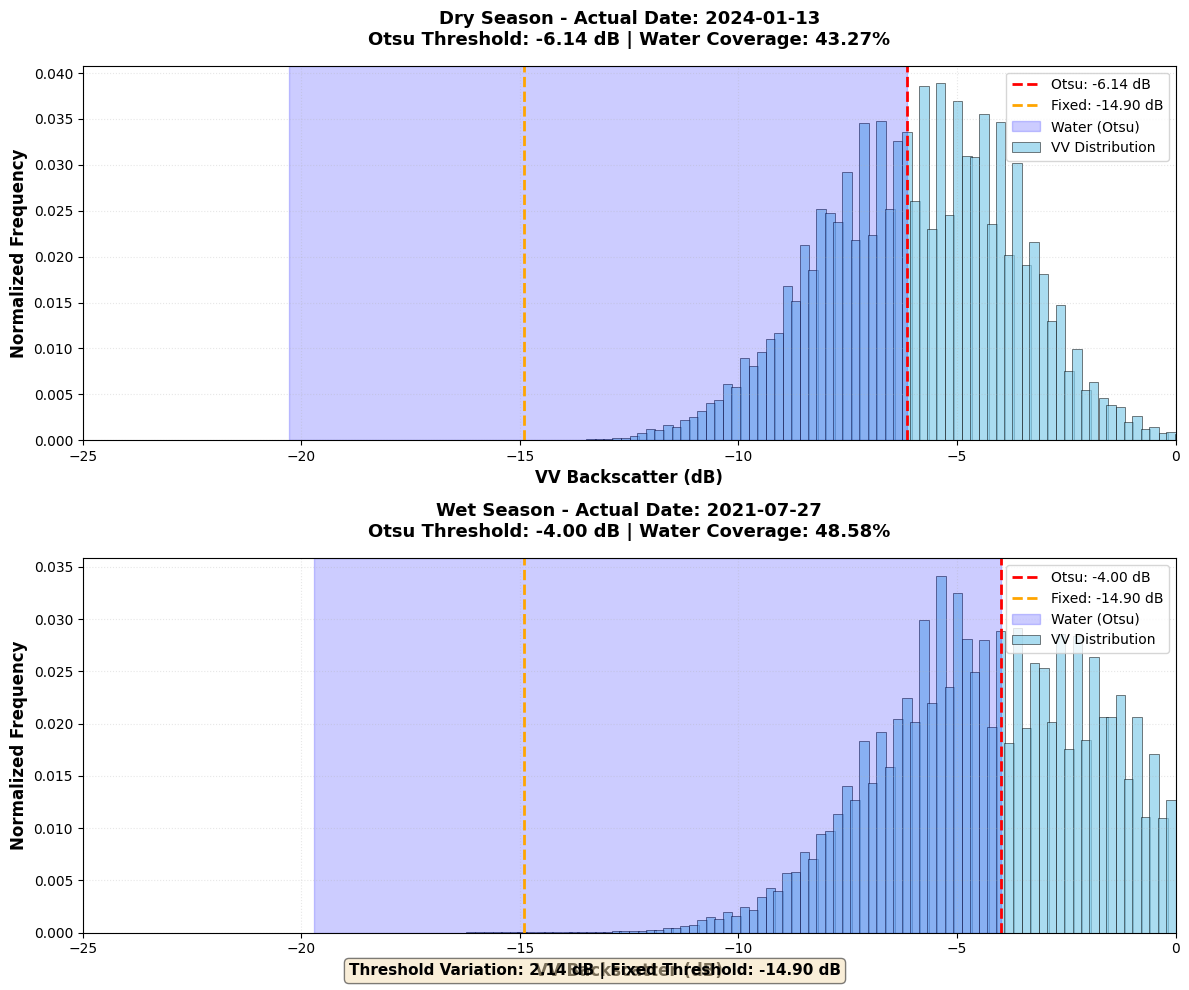

In [14]:
#!/usr/bin/env python3
"""
Otsu Threshold Validation for SAR Water Detection
Compares threshold calculation between dry and wet dates
"""

import ee
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict
from datetime import datetime, timedelta

# Initialize Earth Engine with high-volume endpoint
print("Initializing Earth Engine...")
try:
    ee.Initialize(project='kolkata-flood-mapping')
    print("✅ Earth Engine initialized successfully")
except Exception as e:
    print(f"❌ Failed to initialize Earth Engine.")
    print(f"   Error: {e}")
    print(f"\n💡 Try running: earthengine authenticate")
    raise

# Constants
KMC_BBOX = [88.24, 22.45, 88.46, 22.63]
DRY_DATE = '2024-01-15'  # Target dry date
WET_DATE = '2021-07-30'  # Target wet date
FIXED_THRESHOLD = -14.90
DATE_SEARCH_WINDOW = 7  # Search ±7 days around target date


def get_sentinel1_image(target_date: str, bbox: list,
                        search_window_days: int = DATE_SEARCH_WINDOW) -> tuple:
    """
    Load and preprocess Sentinel-1 image closest to target date.

    Args:
        target_date: Target date string in 'YYYY-MM-DD' format
        bbox: Bounding box [minLon, minLat, maxLon, maxLat]
        search_window_days: Number of days to search before/after target date

    Returns:
        Tuple of (preprocessed VV image, actual acquisition date)
    """
    region = ee.Geometry.Rectangle(bbox)

    # Calculate search date range
    target = datetime.strptime(target_date, '%Y-%m-%d')
    start_date = (target - timedelta(days=search_window_days)).strftime('%Y-%m-%d')
    end_date = (target + timedelta(days=search_window_days)).strftime('%Y-%m-%d')

    print(f"  Searching from {start_date} to {end_date}")

    # Load Sentinel-1 collection
    collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                  .filterBounds(region)
                  .filterDate(start_date, end_date)
                  .filter(ee.Filter.eq('instrumentMode', 'IW'))
                  .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                  .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')))

    # Check collection size
    size = collection.size().getInfo()
    if size == 0:
        raise ValueError(
            f"No Sentinel-1 image found between {start_date} and {end_date}.\n"
            f"  Try increasing DATE_SEARCH_WINDOW (currently {search_window_days} days)"
        )

    print(f"  Found {size} image(s) in date range")

    # Get the image closest to target date
    # Sort by absolute difference from target date
    target_millis = ee.Date(target_date).millis()

    def add_time_diff(img):
        time_diff = ee.Number(img.date().millis()).subtract(target_millis).abs()
        return img.set('time_diff', time_diff)

    collection_with_diff = collection.map(add_time_diff)
    closest_image = collection_with_diff.sort('time_diff').first()

    # Get actual acquisition date
    actual_date_millis = closest_image.date().millis().getInfo()
    actual_date = datetime.fromtimestamp(actual_date_millis / 1000).strftime('%Y-%m-%d')

    days_diff = abs((datetime.strptime(actual_date, '%Y-%m-%d') - target).days)
    print(f"  Using image from {actual_date} ({days_diff} days from target)")

    # Select VV band and apply 100m focal median filter
    vv = closest_image.select('VV')
    vv_filtered = vv.focal_median(radius=100, kernelType='circle', units='meters')

    return vv_filtered, actual_date


def get_histogram_data(image: ee.Image, region: ee.Geometry,
                       min_val: float = -25, max_val: float = 0,
                       bins: int = 256) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extract histogram data from Earth Engine image.

    Args:
        image: Earth Engine image
        region: Region of interest
        min_val: Minimum value for histogram
        max_val: Maximum value for histogram
        bins: Number of histogram bins

    Returns:
        Tuple of (bin_edges, counts)
    """
    # Compute histogram on server-side
    histogram = image.reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=bins, minBucketWidth=(max_val - min_val) / bins),
        geometry=region,
        scale=10,
        maxPixels=1e9,
        bestEffort=True
    )

    # Get histogram data
    hist_data = histogram.getInfo()

    if not hist_data or 'VV' not in hist_data:
        raise ValueError("Failed to compute histogram")

    hist_dict = hist_data['VV']
    bucket_means = np.array(hist_dict['bucketMeans'])
    bucket_counts = np.array(hist_dict['histogram'])

    print(f"  Histogram: {len(bucket_means)} bins, {int(np.sum(bucket_counts)):,} total pixels")

    return bucket_means, bucket_counts


def otsu_threshold(hist_counts: np.ndarray, bin_centers: np.ndarray) -> float:
    """
    Calculate optimal threshold using Otsu's method.

    Otsu's method maximizes the between-class variance by finding the threshold
    that best separates two classes (water vs non-water).

    Args:
        hist_counts: Histogram counts for each bin
        bin_centers: Center values for each histogram bin

    Returns:
        Optimal threshold value in dB
    """
    # Normalize histogram to get probability distribution
    total = np.sum(hist_counts)
    if total == 0:
        raise ValueError("Empty histogram")

    prob = hist_counts / total

    # Calculate cumulative sums
    omega = np.cumsum(prob)  # Cumulative probability
    mu = np.cumsum(prob * bin_centers)  # Cumulative mean
    mu_t = mu[-1]  # Total mean

    # Avoid division by zero
    omega = np.clip(omega, 1e-10, 1.0)

    # Calculate between-class variance for each possible threshold
    sigma_b_squared = ((mu_t * omega - mu) ** 2) / (omega * (1 - omega))

    # Handle NaN values
    sigma_b_squared = np.nan_to_num(sigma_b_squared)

    # Find the threshold that maximizes between-class variance
    max_idx = np.argmax(sigma_b_squared)
    threshold = bin_centers[max_idx]

    return threshold


def analyze_date(target_date: str, bbox: list, label: str) -> Dict:
    """
    Analyze a single date and compute Otsu threshold.

    Args:
        target_date: Target date string
        bbox: Bounding box
        label: Label for this analysis (e.g., "Dry" or "Wet")

    Returns:
        Dictionary with analysis results
    """
    print(f"\n{'='*60}")
    print(f"Analyzing {label} Date: {target_date}")
    print(f"{'='*60}")

    region = ee.Geometry.Rectangle(bbox)

    # Load and preprocess image
    print("Loading Sentinel-1 image...")
    image, actual_date = get_sentinel1_image(target_date, bbox)

    # Get histogram data
    print("Computing histogram...")
    bin_centers, counts = get_histogram_data(image, region)

    # Calculate Otsu threshold
    print("Calculating Otsu threshold...")
    threshold = otsu_threshold(counts, bin_centers)

    # Calculate statistics
    total_pixels = np.sum(counts)
    water_pixels_otsu = np.sum(counts[bin_centers < threshold])
    water_pixels_fixed = np.sum(counts[bin_centers < FIXED_THRESHOLD])

    water_pct_otsu = (water_pixels_otsu / total_pixels) * 100
    water_pct_fixed = (water_pixels_fixed / total_pixels) * 100

    print(f"\n📊 Results for {label} Date:")
    print(f"  Target Date:           {target_date}")
    print(f"  Actual Date:           {actual_date}")
    print(f"  Otsu Threshold:        {threshold:.2f} dB")
    print(f"  Fixed Threshold:       {FIXED_THRESHOLD:.2f} dB")
    print(f"  Difference:            {abs(threshold - FIXED_THRESHOLD):.2f} dB")
    print(f"  Water % (Otsu):        {water_pct_otsu:.2f}%")
    print(f"  Water % (Fixed):       {water_pct_fixed:.2f}%")

    return {
        'target_date': target_date,
        'actual_date': actual_date,
        'label': label,
        'bin_centers': bin_centers,
        'counts': counts,
        'threshold': threshold,
        'water_pct_otsu': water_pct_otsu,
        'water_pct_fixed': water_pct_fixed
    }


def plot_comparison(dry_results: Dict, wet_results: Dict):
    """
    Create comparison plot of histograms and thresholds.

    Args:
        dry_results: Results dictionary for dry date
        wet_results: Results dictionary for wet date
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    for idx, (results, ax) in enumerate([(dry_results, axes[0]), (wet_results, axes[1])]):
        # Normalize counts for better visualization
        normalized_counts = results['counts'] / np.sum(results['counts'])

        # Plot histogram
        ax.bar(results['bin_centers'], normalized_counts,
               width=np.diff(results['bin_centers'])[0] * 0.8,
               alpha=0.7, color='skyblue', edgecolor='black', linewidth=0.5,
               label='VV Distribution')

        # Plot Otsu threshold
        ax.axvline(results['threshold'], color='red', linestyle='--',
                   linewidth=2, label=f"Otsu: {results['threshold']:.2f} dB")

        # Plot fixed threshold
        ax.axvline(FIXED_THRESHOLD, color='orange', linestyle='--',
                   linewidth=2, label=f"Fixed: {FIXED_THRESHOLD:.2f} dB")

        # Shade water region (below Otsu threshold)
        ax.axvspan(results['bin_centers'][0], results['threshold'],
                   alpha=0.2, color='blue', label='Water (Otsu)')

        # Labels and formatting
        ax.set_xlabel('VV Backscatter (dB)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Normalized Frequency', fontsize=12, fontweight='bold')
        ax.set_title(f'{results["label"]} Season - Actual Date: {results["actual_date"]}\n'
                    f'Otsu Threshold: {results["threshold"]:.2f} dB | '
                    f'Water Coverage: {results["water_pct_otsu"]:.2f}%',
                    fontsize=13, fontweight='bold', pad=15)
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle=':')
        ax.set_xlim([-25, 0])

    plt.tight_layout()

    # Summary text
    fig.text(0.5, 0.02,
             f'Threshold Variation: {abs(dry_results["threshold"] - wet_results["threshold"]):.2f} dB | '
             f'Fixed Threshold: {FIXED_THRESHOLD:.2f} dB',
             ha='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.savefig('data/sar/otsu_validation_comparison.png', dpi=300, bbox_inches='tight')
    print(f"\n💾 Plot saved to: data/sar/otsu_validation_comparison.png")
    plt.show()


def main():
    """Main execution function."""
    print("="*60)
    print("OTSU THRESHOLD VALIDATION FOR SAR WATER DETECTION")
    print("="*60)
    print(f"Region: Kolkata Municipal Corporation")
    print(f"Bounding Box: {KMC_BBOX}")
    print(f"Fixed Threshold: {FIXED_THRESHOLD} dB")
    print(f"Date Search Window: ±{DATE_SEARCH_WINDOW} days")

    try:
        # Analyze dry date
        dry_results = analyze_date(DRY_DATE, KMC_BBOX, "Dry")

        # Analyze wet date
        wet_results = analyze_date(WET_DATE, KMC_BBOX, "Wet")

        # Summary comparison
        print(f"\n{'='*60}")
        print("SUMMARY COMPARISON")
        print(f"{'='*60}")
        threshold_diff = abs(dry_results['threshold'] - wet_results['threshold'])
        print(f"Threshold Variation:   {threshold_diff:.2f} dB")
        print(f"Dry Date Threshold:    {dry_results['threshold']:.2f} dB ({dry_results['actual_date']})")
        print(f"Wet Date Threshold:    {wet_results['threshold']:.2f} dB ({wet_results['actual_date']})")

        # Interpretation
        print(f"\n📝 Interpretation:")
        if threshold_diff < 1.0:
            print("  ✅ LOW variation - Otsu is relatively stable across conditions")
            print("  ✅ Fixed threshold approach is reasonable")
        elif threshold_diff < 2.0:
            print("  ⚠️  MODERATE variation - Consider seasonal adjustment")
            print("  ⚠️  Fixed threshold may introduce bias")
        else:
            print("  ❌ HIGH variation - Fixed threshold NOT recommended")
            print("  ❌ Use adaptive (Otsu) or scene-specific thresholds")

        # Check if fixed threshold is reasonable
        avg_otsu = (dry_results['threshold'] + wet_results['threshold']) / 2
        print(f"\n  Average Otsu Threshold: {avg_otsu:.2f} dB")
        print(f"  Your Fixed Threshold:   {FIXED_THRESHOLD:.2f} dB")
        print(f"  Difference from Avg:    {abs(avg_otsu - FIXED_THRESHOLD):.2f} dB")

        # Generate plot
        plot_comparison(dry_results, wet_results)

        print(f"\n{'='*60}")
        print("✅ Validation Complete!")
        print(f"{'='*60}")

    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()


main()

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Add this function to your script
def diagnostic_histogram_analysis(results_dict):
    """Deep dive into what Otsu is actually seeing."""

    bin_centers = results_dict['bin_centers']
    counts = results_dict['counts']
    threshold = results_dict['threshold']

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Linear scale histogram
    ax = axes[0, 0]
    ax.bar(bin_centers, counts, width=np.diff(bin_centers)[0]*0.8, alpha=0.7)
    ax.axvline(threshold, color='red', linewidth=2, label=f'Otsu: {threshold:.2f}')
    ax.axvline(-14.90, color='orange', linewidth=2, label=f'Fixed: -14.90')
    ax.set_xlabel('VV Backscatter (dB)')
    ax.set_ylabel('Pixel Count')
    ax.set_title('Histogram - Linear Scale')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Log scale histogram (to see small peaks)
    ax = axes[0, 1]
    ax.bar(bin_centers, counts, width=np.diff(bin_centers)[0]*0.8, alpha=0.7)
    ax.axvline(threshold, color='red', linewidth=2, label=f'Otsu: {threshold:.2f}')
    ax.axvline(-14.90, color='orange', linewidth=2, label=f'Fixed: -14.90')
    ax.set_xlabel('VV Backscatter (dB)')
    ax.set_ylabel('Pixel Count (log scale)')
    ax.set_yscale('log')
    ax.set_title('Histogram - Log Scale (reveals small peaks)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Between-class variance curve (Otsu's objective function)
    prob = counts / np.sum(counts)
    omega = np.cumsum(prob)
    mu = np.cumsum(prob * bin_centers)
    mu_t = mu[-1]
    omega = np.clip(omega, 1e-10, 1.0)
    sigma_b_squared = ((mu_t * omega - mu) ** 2) / (omega * (1 - omega))
    sigma_b_squared = np.nan_to_num(sigma_b_squared)

    ax = axes[1, 0]
    ax.plot(bin_centers, sigma_b_squared, linewidth=2)
    ax.axvline(threshold, color='red', linewidth=2, linestyle='--',
               label=f'Otsu Maximum: {threshold:.2f}')
    ax.set_xlabel('Threshold (dB)')
    ax.set_ylabel('Between-Class Variance')
    ax.set_title('Otsu Objective Function\n(What Otsu is maximizing)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Cumulative distribution
    ax = axes[1, 1]
    cumsum = np.cumsum(counts) / np.sum(counts) * 100
    ax.plot(bin_centers, cumsum, linewidth=2)
    ax.axvline(threshold, color='red', linewidth=2, label=f'Otsu: {threshold:.2f} ({cumsum[np.argmin(np.abs(bin_centers - threshold))]:.1f}%)')
    ax.axvline(-14.90, color='orange', linewidth=2, label=f'Fixed: -14.90 ({cumsum[np.argmin(np.abs(bin_centers - (-14.90)))]:.1f}%)')
    ax.set_xlabel('VV Backscatter (dB)')
    ax.set_ylabel('Cumulative % of Pixels')
    ax.set_title('Cumulative Distribution\n(Shows class imbalance)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'diagnostic_histogram_{results_dict["label"]}.png', dpi=300)
    print(f"Saved diagnostic plot: diagnostic_histogram_{results_dict['label']}.png")
    plt.show()

# After analyzing each date, call:
diagnostic_histogram_analysis(dry_results)
diagnostic_histogram_analysis(wet_results)

NameError: name 'dry_results' is not defined

Initializing Earth Engine...
✅ Earth Engine initialized successfully
OTSU THRESHOLD VALIDATION - COMPLETE ANALYSIS
Region: Kolkata Municipal Corporation
Bounding Box: [88.24, 22.45, 88.46, 22.63]
Fixed Threshold: -14.9 dB
Date Search Window: ±7 days

Analyzing Dry Date: 2024-01-15
Loading Sentinel-1 image...
  Searching from 2024-01-08 to 2024-01-22
  Found 3 image(s) in date range
  Using image from 2024-01-13 (2 days from target)
Computing histogram...
  Histogram: 153 bins, 757,085 total pixels
Calculating Otsu threshold...

📊 Results for Dry Date:
  Target Date:           2024-01-15
  Actual Date:           2024-01-13
  Otsu Threshold:        -6.14 dB
  Fixed Threshold:       -14.90 dB
  Difference:            8.76 dB
  Water % (Otsu):        43.27%
  Water % (Fixed):       0.10%

Analyzing Wet Date: 2021-07-30
Loading Sentinel-1 image...
  Searching from 2021-07-23 to 2021-08-06
  Found 3 image(s) in date range
  Using image from 2021-07-27 (3 days from target)
Computing histogram

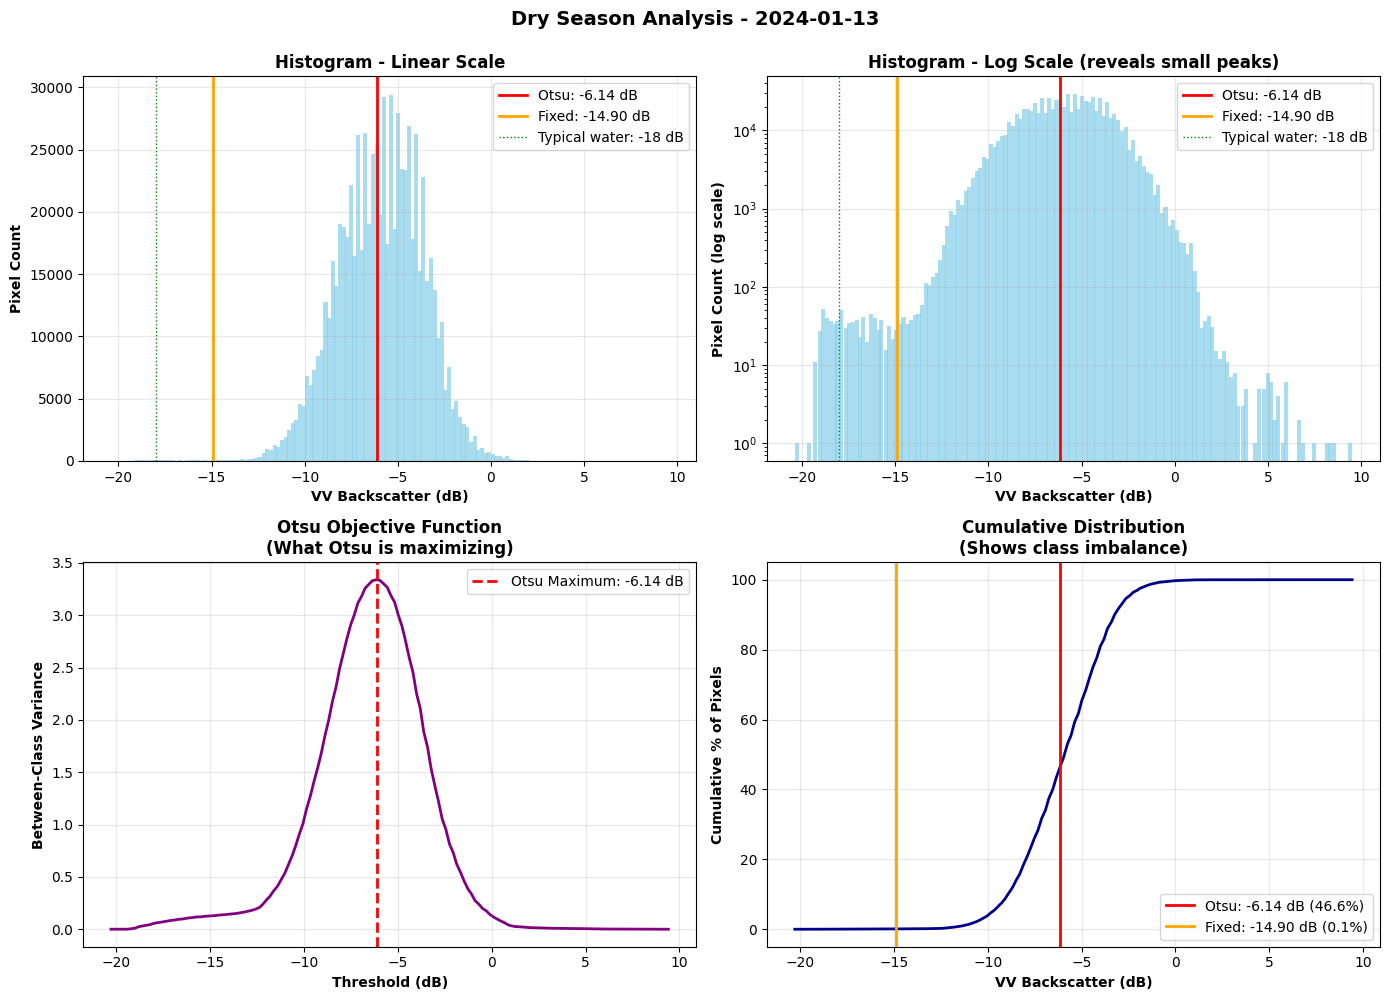


✅ Saved diagnostic plot to PROJECT ROOT:
   Path: /Users/romitbasak/Projects/KolkataFloodMapping/data/sar/diagnostic_histogram_wet.png
   Size: 398.9 KB


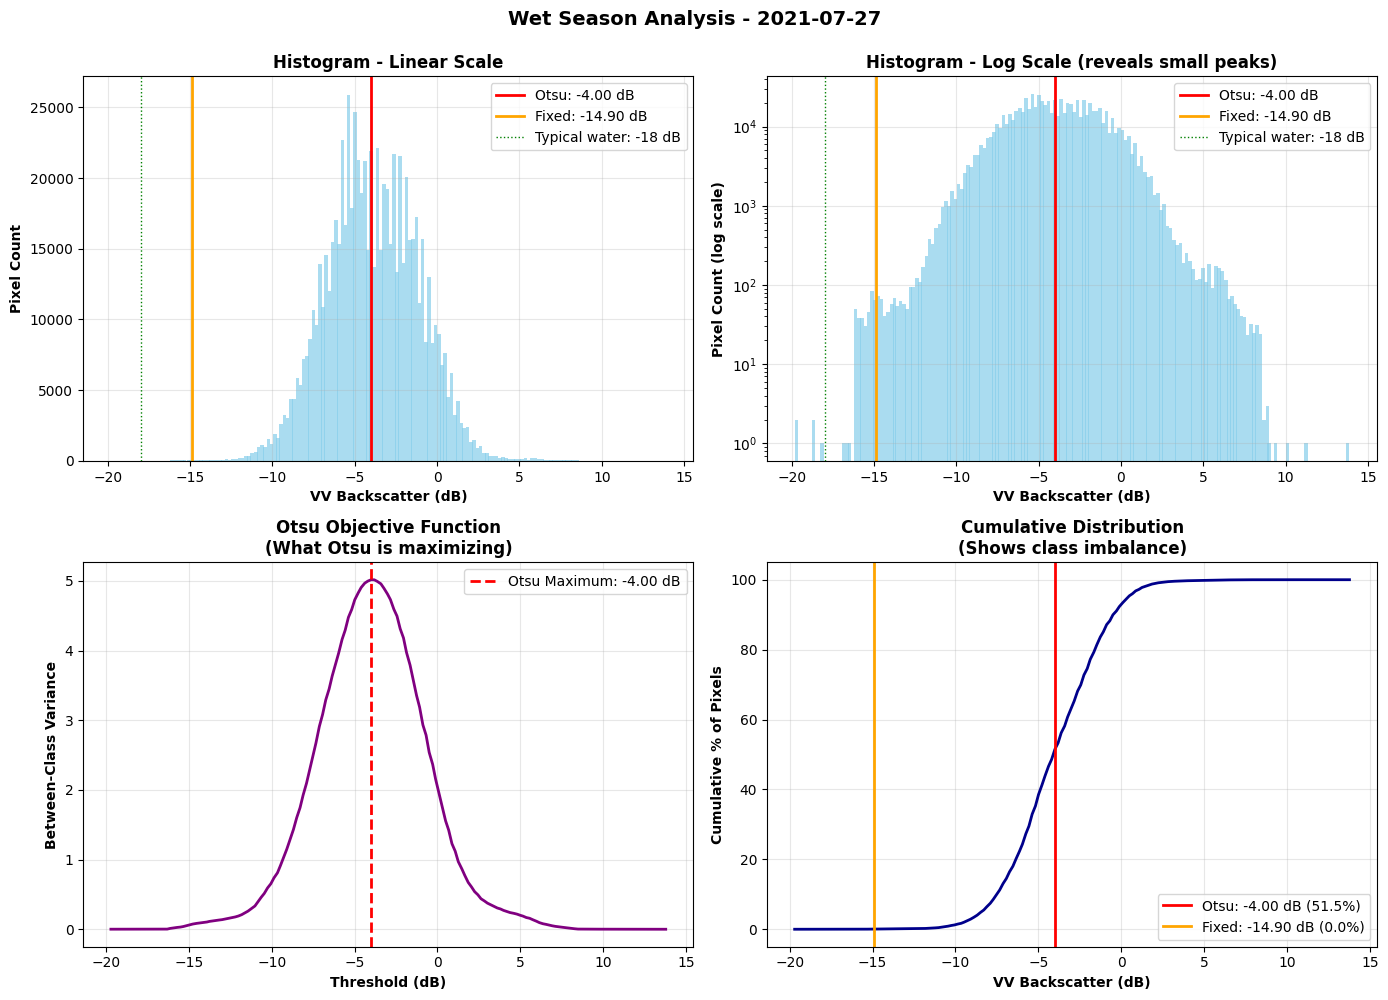


✅ Analysis Complete!

📊 Check the diagnostic plots to see:
  1. Histogram shape (bimodal or unimodal?)
  2. Where Otsu is finding its maximum
  3. Cumulative distribution (class balance)
  4. Whether water is a visible separate peak


In [21]:
#!/usr/bin/env python3
"""
Otsu Threshold Validation for SAR Water Detection - Complete Analysis
"""

import ee
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict
from datetime import datetime, timedelta
import os

# Initialize Earth Engine
print("Initializing Earth Engine...")
try:
    ee.Initialize(project='kolkata-flood-mapping')
    print("✅ Earth Engine initialized successfully")
except Exception as e:
    print(f"❌ Failed to initialize Earth Engine: {e}")
    raise

# Constants
KMC_BBOX = [88.24, 22.45, 88.46, 22.63]
DRY_DATE = '2024-01-15'
WET_DATE = '2021-07-30'
FIXED_THRESHOLD = -14.90
DATE_SEARCH_WINDOW = 7


def get_sentinel1_image(target_date: str, bbox: list,
                        search_window_days: int = DATE_SEARCH_WINDOW) -> tuple:
    """Load and preprocess Sentinel-1 image closest to target date."""
    region = ee.Geometry.Rectangle(bbox)

    target = datetime.strptime(target_date, '%Y-%m-%d')
    start_date = (target - timedelta(days=search_window_days)).strftime('%Y-%m-%d')
    end_date = (target + timedelta(days=search_window_days)).strftime('%Y-%m-%d')

    print(f"  Searching from {start_date} to {end_date}")

    collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                  .filterBounds(region)
                  .filterDate(start_date, end_date)
                  .filter(ee.Filter.eq('instrumentMode', 'IW'))
                  .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                  .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')))

    size = collection.size().getInfo()
    if size == 0:
        raise ValueError(f"No Sentinel-1 image found between {start_date} and {end_date}")

    print(f"  Found {size} image(s) in date range")

    target_millis = ee.Date(target_date).millis()

    def add_time_diff(img):
        time_diff = ee.Number(img.date().millis()).subtract(target_millis).abs()
        return img.set('time_diff', time_diff)

    collection_with_diff = collection.map(add_time_diff)
    closest_image = collection_with_diff.sort('time_diff').first()

    actual_date_millis = closest_image.date().millis().getInfo()
    actual_date = datetime.fromtimestamp(actual_date_millis / 1000).strftime('%Y-%m-%d')

    days_diff = abs((datetime.strptime(actual_date, '%Y-%m-%d') - target).days)
    print(f"  Using image from {actual_date} ({days_diff} days from target)")

    vv = closest_image.select('VV')
    vv_filtered = vv.focal_median(radius=100, kernelType='circle', units='meters')

    return vv_filtered, actual_date


def get_histogram_data(image: ee.Image, region: ee.Geometry,
                       min_val: float = -25, max_val: float = 0,
                       bins: int = 256) -> Tuple[np.ndarray, np.ndarray]:
    """Extract histogram data from Earth Engine image."""
    histogram = image.reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=bins, minBucketWidth=(max_val - min_val) / bins),
        geometry=region,
        scale=10,
        maxPixels=1e9,
        bestEffort=True
    )

    hist_data = histogram.getInfo()

    if not hist_data or 'VV' not in hist_data:
        raise ValueError("Failed to compute histogram")

    hist_dict = hist_data['VV']
    bucket_means = np.array(hist_dict['bucketMeans'])
    bucket_counts = np.array(hist_dict['histogram'])

    print(f"  Histogram: {len(bucket_means)} bins, {int(np.sum(bucket_counts)):,} total pixels")

    return bucket_means, bucket_counts


def otsu_threshold(hist_counts: np.ndarray, bin_centers: np.ndarray) -> float:
    """Calculate optimal threshold using Otsu's method."""
    total = np.sum(hist_counts)
    if total == 0:
        raise ValueError("Empty histogram")

    prob = hist_counts / total
    omega = np.cumsum(prob)
    mu = np.cumsum(prob * bin_centers)
    mu_t = mu[-1]
    omega = np.clip(omega, 1e-10, 1.0)

    with np.errstate(divide='ignore', invalid='ignore'):
        sigma_b_squared = ((mu_t * omega - mu) ** 2) / (omega * (1 - omega))

    sigma_b_squared = np.nan_to_num(sigma_b_squared)
    max_idx = np.argmax(sigma_b_squared)
    threshold = bin_centers[max_idx]

    return threshold


def analyze_date(target_date: str, bbox: list, label: str) -> Dict:
    """Analyze a single date and compute Otsu threshold."""
    print(f"\n{'='*60}")
    print(f"Analyzing {label} Date: {target_date}")
    print(f"{'='*60}")

    region = ee.Geometry.Rectangle(bbox)

    print("Loading Sentinel-1 image...")
    image, actual_date = get_sentinel1_image(target_date, bbox)

    print("Computing histogram...")
    bin_centers, counts = get_histogram_data(image, region)

    print("Calculating Otsu threshold...")
    threshold = otsu_threshold(counts, bin_centers)

    total_pixels = np.sum(counts)
    water_pixels_otsu = np.sum(counts[bin_centers < threshold])
    water_pixels_fixed = np.sum(counts[bin_centers < FIXED_THRESHOLD])

    water_pct_otsu = (water_pixels_otsu / total_pixels) * 100
    water_pct_fixed = (water_pixels_fixed / total_pixels) * 100

    print(f"\n📊 Results for {label} Date:")
    print(f"  Target Date:           {target_date}")
    print(f"  Actual Date:           {actual_date}")
    print(f"  Otsu Threshold:        {threshold:.2f} dB")
    print(f"  Fixed Threshold:       {FIXED_THRESHOLD:.2f} dB")
    print(f"  Difference:            {abs(threshold - FIXED_THRESHOLD):.2f} dB")
    print(f"  Water % (Otsu):        {water_pct_otsu:.2f}%")
    print(f"  Water % (Fixed):       {water_pct_fixed:.2f}%")

    return {
        'target_date': target_date,
        'actual_date': actual_date,
        'label': label,
        'bin_centers': bin_centers,
        'counts': counts,
        'threshold': threshold,
        'water_pct_otsu': water_pct_otsu,
        'water_pct_fixed': water_pct_fixed
    }


def diagnostic_histogram_analysis(results_dict):
    """Deep dive into what Otsu is actually seeing."""

    bin_centers = results_dict['bin_centers']
    counts = results_dict['counts']
    threshold = results_dict['threshold']
    label = results_dict['label']

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Linear scale histogram
    ax = axes[0, 0]
    ax.bar(bin_centers, counts, width=np.diff(bin_centers)[0]*0.8, alpha=0.7, color='skyblue')
    ax.axvline(threshold, color='red', linewidth=2, label=f'Otsu: {threshold:.2f} dB')
    ax.axvline(-14.90, color='orange', linewidth=2, label=f'Fixed: -14.90 dB')
    ax.axvline(-18, color='green', linewidth=1, linestyle=':', label='Typical water: -18 dB')
    ax.set_xlabel('VV Backscatter (dB)', fontweight='bold')
    ax.set_ylabel('Pixel Count', fontweight='bold')
    ax.set_title('Histogram - Linear Scale', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Log scale histogram (to see small peaks)
    ax = axes[0, 1]
    ax.bar(bin_centers, counts, width=np.diff(bin_centers)[0]*0.8, alpha=0.7, color='skyblue')
    ax.axvline(threshold, color='red', linewidth=2, label=f'Otsu: {threshold:.2f} dB')
    ax.axvline(-14.90, color='orange', linewidth=2, label=f'Fixed: -14.90 dB')
    ax.axvline(-18, color='green', linewidth=1, linestyle=':', label='Typical water: -18 dB')
    ax.set_xlabel('VV Backscatter (dB)', fontweight='bold')
    ax.set_ylabel('Pixel Count (log scale)', fontweight='bold')
    ax.set_yscale('log')
    ax.set_title('Histogram - Log Scale (reveals small peaks)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Between-class variance curve (Otsu's objective function)
    prob = counts / np.sum(counts)
    omega = np.cumsum(prob)
    mu = np.cumsum(prob * bin_centers)
    mu_t = mu[-1]
    omega = np.clip(omega, 1e-10, 1.0)

    with np.errstate(divide='ignore', invalid='ignore'):
        sigma_b_squared = ((mu_t * omega - mu) ** 2) / (omega * (1 - omega))

    sigma_b_squared = np.nan_to_num(sigma_b_squared)

    ax = axes[1, 0]
    ax.plot(bin_centers, sigma_b_squared, linewidth=2, color='purple')
    ax.axvline(threshold, color='red', linewidth=2, linestyle='--',
               label=f'Otsu Maximum: {threshold:.2f} dB')
    ax.set_xlabel('Threshold (dB)', fontweight='bold')
    ax.set_ylabel('Between-Class Variance', fontweight='bold')
    ax.set_title('Otsu Objective Function\n(What Otsu is maximizing)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Cumulative distribution
    ax = axes[1, 1]
    cumsum = np.cumsum(counts) / np.sum(counts) * 100
    ax.plot(bin_centers, cumsum, linewidth=2, color='darkblue')

    otsu_idx = np.argmin(np.abs(bin_centers - threshold))
    fixed_idx = np.argmin(np.abs(bin_centers - (-14.90)))

    ax.axvline(threshold, color='red', linewidth=2,
               label=f'Otsu: {threshold:.2f} dB ({cumsum[otsu_idx]:.1f}%)')
    ax.axvline(-14.90, color='orange', linewidth=2,
               label=f'Fixed: -14.90 dB ({cumsum[fixed_idx]:.1f}%)')
    ax.set_xlabel('VV Backscatter (dB)', fontweight='bold')
    ax.set_ylabel('Cumulative % of Pixels', fontweight='bold')
    ax.set_title('Cumulative Distribution\n(Shows class imbalance)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.suptitle(f'{label} Season Analysis - {results_dict["actual_date"]}',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()

    # Save to PROJECT ROOT (KolkataFloodMapping/data/sar/), not notebooks/data/sar/
    try:
        # Get project root (one level up from current working directory)
        project_root = os.path.dirname(os.getcwd())
        save_dir = os.path.join(project_root, 'data', 'sar')
        os.makedirs(save_dir, exist_ok=True)

        filename = f'diagnostic_histogram_{label.lower()}.png'
        filepath = os.path.join(save_dir, filename)

        # Save the figure
        plt.savefig(filepath, dpi=300, bbox_inches='tight')

        # Verify the file was created
        if os.path.exists(filepath):
            abs_path = os.path.abspath(filepath)
            file_size = os.path.getsize(filepath) / 1024  # KB
            print(f"\n✅ Saved diagnostic plot to PROJECT ROOT:")
            print(f"   Path: {abs_path}")
            print(f"   Size: {file_size:.1f} KB")
        else:
            print(f"\n⚠️ File save reported success but file not found at: {filepath}")

    except Exception as e:
        print(f"\n❌ Error saving to project root: {e}")
        # Fallback: save to notebooks/data/sar/
        try:
            fallback_dir = 'data/sar'
            os.makedirs(fallback_dir, exist_ok=True)
            fallback_filename = f'diagnostic_histogram_{label.lower()}.png'
            fallback_path = os.path.join(fallback_dir, fallback_filename)
            plt.savefig(fallback_path, dpi=300, bbox_inches='tight')
            if os.path.exists(fallback_path):
                abs_path = os.path.abspath(fallback_path)
                print(f"\n✅ Saved to notebooks/data/sar/ instead:")
                print(f"   Path: {abs_path}")
        except Exception as e2:
            print(f"\n❌ Could not save file anywhere: {e2}")

    plt.show()


def main():
    """Main execution function."""
    print("="*60)
    print("OTSU THRESHOLD VALIDATION - COMPLETE ANALYSIS")
    print("="*60)
    print(f"Region: Kolkata Municipal Corporation")
    print(f"Bounding Box: {KMC_BBOX}")
    print(f"Fixed Threshold: {FIXED_THRESHOLD} dB")
    print(f"Date Search Window: ±{DATE_SEARCH_WINDOW} days")

    try:
        # Analyze dry date
        dry_results = analyze_date(DRY_DATE, KMC_BBOX, "Dry")

        # Analyze wet date
        wet_results = analyze_date(WET_DATE, KMC_BBOX, "Wet")

        # Summary comparison
        print(f"\n{'='*60}")
        print("SUMMARY COMPARISON")
        print(f"{'='*60}")
        threshold_diff = abs(dry_results['threshold'] - wet_results['threshold'])
        print(f"Threshold Variation:   {threshold_diff:.2f} dB")
        print(f"Dry Date Threshold:    {dry_results['threshold']:.2f} dB ({dry_results['actual_date']})")
        print(f"Wet Date Threshold:    {wet_results['threshold']:.2f} dB ({wet_results['actual_date']})")

        # Generate diagnostic plots
        print(f"\n{'='*60}")
        print("GENERATING DIAGNOSTIC PLOTS")
        print(f"{'='*60}")

        diagnostic_histogram_analysis(dry_results)
        diagnostic_histogram_analysis(wet_results)

        print(f"\n{'='*60}")
        print("✅ Analysis Complete!")
        print(f"{'='*60}")
        print("\n📊 Check the diagnostic plots to see:")
        print("  1. Histogram shape (bimodal or unimodal?)")
        print("  2. Where Otsu is finding its maximum")
        print("  3. Cumulative distribution (class balance)")
        print("  4. Whether water is a visible separate peak")

    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()

main()